In [44]:
from sys import path
path.append("/home/ec2-user/SageMaker/data-science-development/utils")
path.append("/home/ec2-user/SageMaker/data-science-development/config")

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

import os
import torch
# import sktime

from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader

from redshift import get_from_redshift
from datetime import datetime
from config import Config  

from tqdm import tqdm 

tqdm.pandas()

In [45]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_work_experience) 

In [46]:
candidate_work_experience = get_from_redshift(sql_path, Config.redshift_creds)
candidate_work_experience.head()

,candidate_id,unique_id,date_start_job,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source
0,85712,8739639,2017-12-14 00:00:00,2018-08-01,2338.0,2.0,4321.0,None,Tapfin inz UPS SP (HFD),plaatsing
1,85712,8777822,2018-01-22 00:00:00,2018-01-24,2038.0,1.0,9329.0,None,Arvato Benelux BV,plaatsing
2,85712,9977222,2020-07-27 00:00:00,2020-12-14,2038.0,1.0,9329.0,None,Koninklijke de Ruyter B.V.,plaatsing
3,85712,9981694,2020-08-02 00:00:00,2020-08-10,2038.0,1.0,9329.0,Productiemedewerker,Grozette BV,plaatsing
4,85888,15682354,2009-02-01 00:00:00,2011-02-01,NaN,NaN,NaN,beheerder,eurest catering,dossier


In [47]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_education) 

In [48]:
candidate_education = get_from_redshift(sql_path, Config.redshift_creds)
candidate_education.head()

,candidate_id,education_level,date_start,date_end,date_registrated,passed
0,120605,3,2000-01-01 00:00:00,2001-01-01 00:00:00,2005-08-02 15:21:18,1
1,162756,3,1987-09-02 00:00:00,1990-06-26 00:00:00,2005-08-09 17:38:46,1
2,243955,2,1978-09-01 00:00:00,1982-06-01 00:00:00,2005-08-16 17:09:23,1
3,365799,2,1995-01-01 00:00:00,1999-01-01 00:00:00,2005-08-23 15:29:10,1
4,383553,2,1991-09-01 00:00:00,1996-06-01 00:00:00,2005-08-30 11:28:29,1


In [49]:
def clean_df(df, table = "work_experience"):
    
    if table == "work_experience":
        start, end = "date_start_job", "date_end_job"
    elif table == "education":
        start, end = "date_start", "date_end"
    else:
        return NotImplemented
    
    # Drop nonsense data
    df = df[df[start] >= dt.datetime(1800, 1, 1)]
    df = df[df[end] <= dt.datetime(2100, 1, 1)]

    # Convert datetime to date
    df[start] = pd.to_datetime(df[start]).dt.date
    df[end] = pd.to_datetime(df[end]).dt.date
    
    return df
        
candidate_work_experience = clean_df(candidate_work_experience)
candidate_education = clean_df(candidate_education, table = "education")

In [50]:
def find_educations(df_work, df_education):

    # Merge career data with education levels
    career_education = pd.merge(df_work, 
                                df_education, 
                                on = "candidate_id", 
                                how = "left")[["candidate_id",
                                               "date_start_job",
                                               "date_end_job",
                                               "education_level",
                                               "date_start",
                                               "date_end",
                                               "passed"]]
    
    # Filter out education that were not passed (yet) at the time of starting a job
    passed = career_education[(career_education["date_start_job"] >= career_education["date_end"]) & 
                              (career_education["passed"] == 1)]
    
    # Only store the highest education level reached at the start of each job
    education_through_time = passed.groupby(["candidate_id", "date_start_job"])["education_level"].max()
    
    df_work.set_index(["candidate_id", "date_start_job"], inplace=True)

    # Store education data in candidate_work_experience
    df_work["education"] = education_through_time

    # np.nan education = no education
    df_work["education"].fillna(0, inplace=True)

    # Reset index for further data augmentation
    df_work.reset_index(inplace=True)
        
    return df_work

candidate_work_experience = find_educations(candidate_work_experience, candidate_education)

candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,education
0,85712,2017-12-14,8739639,2018-08-01,2338.0,2.0,4321.0,None,Tapfin inz UPS SP (HFD),plaatsing,0.0
1,85712,2018-01-22,8777822,2018-01-24,2038.0,1.0,9329.0,None,Arvato Benelux BV,plaatsing,0.0
2,85712,2020-07-27,9977222,2020-12-14,2038.0,1.0,9329.0,None,Koninklijke de Ruyter B.V.,plaatsing,0.0
3,85712,2020-08-02,9981694,2020-08-10,2038.0,1.0,9329.0,Productiemedewerker,Grozette BV,plaatsing,0.0
4,85888,2009-02-01,15682354,2011-02-01,NaN,NaN,NaN,beheerder,eurest catering,dossier,3.0


In [51]:
id_to_idx = {v : i for i, v in enumerate(sorted(candidate_work_experience["isco_code4"].astype(float).unique()))}
idx_to_id = {i : v for i, v in id_to_idx.items()}

In [52]:
candidate_work_experience.dropna(subset=["isco_code4"], inplace=True)

In [53]:
candidate_work_experience["isco_code4"] = candidate_work_experience["isco_code4"].apply(lambda x: id_to_idx[x] if x in id_to_idx else x)

In [54]:
candidate_work_experience.head()

,candidate_id,date_start_job,unique_id,date_end_job,function_id,isco_functie_niveau,isco_code4,function_name_self,company_name,source,education
0,85712,2017-12-14,8739639,2018-08-01,2338.0,2.0,41,None,Tapfin inz UPS SP (HFD),plaatsing,0.0
1,85712,2018-01-22,8777822,2018-01-24,2038.0,1.0,67,None,Arvato Benelux BV,plaatsing,0.0
2,85712,2020-07-27,9977222,2020-12-14,2038.0,1.0,67,None,Koninklijke de Ruyter B.V.,plaatsing,0.0
3,85712,2020-08-02,9981694,2020-08-10,2038.0,1.0,67,Productiemedewerker,Grozette BV,plaatsing,0.0
5,85888,2011-05-11,5797421,2011-07-31,1046.0,2.0,259,Catering medewerker,Albron Nederland BV/Catering,plaatsing,3.0


In [55]:
def add_order(df):
    
    # Count the number of jobs each candidate has ahd
    job_counts = df.groupby("candidate_id").size()
    
    # Sort by candidate_id, date_start_job
    sorted_df = df.sort_values(by = ['candidate_id', "date_start_job"])
    
    # Reset index
    sorted_df.reset_index(inplace=True, drop=True)
    
    # Create a list of lists containing the order of each candidates jobs (which came first, second, third, etc.)
    order = [np.arange(count) for count in job_counts.values]
    
    # Flatten list
    order = [item for sublist in order for item in sublist]
    
    # Add order to df
    sorted_df["job_order"] = order
    
    # Set a candidate_id, job_order as the index
    return sorted_df.set_index(["candidate_id", 
                                "job_order"])

df = add_order(candidate_work_experience)

In [56]:
df = df[["date_start_job", "date_end_job", "isco_code4", "function_id",
         "isco_functie_niveau", "company_name", "source", "education"]]

df.head(25)

date_start_job date_end_job  isco_code4  function_id  \
candidate_id job_order                                                        
84556        0             2000-08-01   2001-01-04         241       1236.0   
             1             2000-09-07   2001-01-01         368       1065.0   
             2             2000-09-30   2001-07-02         241       1236.0   
             3             2000-10-23   2000-10-27          67       2038.0   
             4             2003-12-22   2004-01-02          67       2038.0   
             5             2004-07-12   2004-07-13          67       2038.0   
             6             2005-04-11   2005-07-01          67       2038.0   
             7             2005-05-25   2005-06-01          67       2038.0   
             8             2005-07-27   2005-08-26          67       2038.0   
             9             2006-03-16   2006-05-15         365       1184.0   
             10            2006-03-16   2006-05-15         365       1184.0   
             11            2006-05-17   2006-07-10         365       1184.0   
             12            2007-01-24   2007-03-03         226        379.0   
             13            2007-07-26   2007-09-01         358       1635.0   
             14            2007-08-11   2007-08-15          44       1496.0   
             15            2007-08-13   2007-09-01         368       1065.0   
             16            2010-01-01   2012-12-01          14       1961.0   
             17            2013-01-01   2014-12-01          15        351.0   
             18            2013-01-01   2014-02-01         226        379.0   
             19            2015-08-17   2015-12-31          67       2038.0   
             20            2015-08-25   2015-12-31          67       2038.0   
             21            2015-11-09   2015-12-31          67       2038.0   
             22            2016-01-21   2016-01-31         257       9004.0   
             23            2016-11-14   2016-11-18          41       2338.0   
84612        0             2000-11-07   2000-11-13          67       2038.0   

                        isco_functie_niveau  \
candidate_id job_order                        
84556        0                          2.0   
             1                          1.0   
             2                          2.0   
             3                          1.0   
             4                          1.0   
             5                          1.0   
             6                          1.0   
             7                          1.0   
             8                          1.0   
             9                          1.0   
             10                         1.0   
             11                         1.0   
             12                         2.0   
             13                         1.0   
             14                         2.0   
             15                         1.0   
             16                         3.0   
             17                         3.0   
             18                         2.0   
             19                         1.0   
             20                         1.0   
             21                         1.0   
             22                         2.0   
             23                         2.0   
84612        0                          1.0   

                                                    company_name     source  \
candidate_id job_order                                                        
84556        0          (oud 3146Amsterdam RAI Catering Services  plaatsing   
             1          (oud 3146Amsterdam RAI Catering Services  plaatsing   
             2              AMSTERDAM RAI CATERING SERVICES B.V.  plaatsing   
             3                                 Formido Bouwmarkt  plaatsing   
             4                             Yakult Nederland B.V.  plaatsing   
             5                             Yakult Nederland B.V.  

In [57]:
df2 = df["isco_code4"]

Text(0, 0.5, 'Number of candidates')

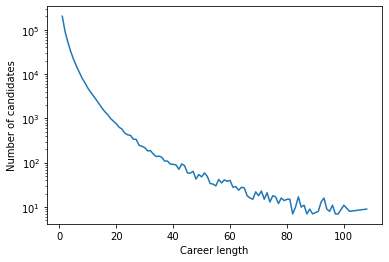

In [59]:
career_lengths = df2.reset_index().groupby("candidate_id")["isco_code4"].count().value_counts()

career_lengths = career_lengths.iloc[:100]

career_lengths.sort_index().plot(logy=True)
plt.xlabel("Career length")
plt.ylabel("Number of candidates")

In [ ]:
def naive_predictor(df):
        
    same = 0
    
    print("Grouping...")
    grouped = df.groupby(level=0)
        
    for idx, (candidate, new_df) in enumerate(grouped):
        
        if idx % 50000 == 0:
            print(f"{idx}/{len(grouped)}")
        
        if len(new_df) > 1:
            same += new_df.iloc[-1] == new_df.iloc[-2]
        else:
            same += 1
            
    return (same / len(df)) * 100
    
naive_predictor(df2)

In [ ]:
dist = df["isco_code4"].value_counts().sort_values(ascending=False).reset_index(drop=True)
dist2 = df["function_id"].value_counts().sort_values(ascending=False).reset_index(drop=True) #.plot(kind="bar", logy = True)

In [ ]:
plt.figure(figsize = (6, 4))
plt.plot(dist.index, np.log(dist.values))

In [ ]:
plt.plot(dist2.index, np.log(dist2.values))

In [ ]:
df_pred = df[["isco_functie_niveau", "education", "function_id"]].fillna(0)

In [ ]:
career_paths = df_pred.groupby(level = 0)

In [ ]:
# TODO: speed this up 
career_paths = career_paths.progress_apply(lambda x: x.values)

In [ ]:
career_paths.apply(len)

In [73]:
# Some dummy time series
x = []
y = []

for i in career_paths.values:
    label = i[-1, -1]
    
    if not np.isnan(label):
        x.append(i[:-1].reshape(len(i) - 1, 3))
        y.append(label)
    
x = np.array(x)
y = np.array(y)

In [74]:
to_fill = np.zeros([len(x), len(max(x, key = lambda x: len(x))), 3])

for i,j in enumerate(x):
    to_fill[i][0:len(j)] = j

In [75]:
data = TensorDataset(torch.Tensor(to_fill), torch.Tensor(y).type(torch.LongTensor))
dataloader = DataLoader(data, batch_size=256, shuffle=True)

In [79]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
               
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
                
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
                
        h_out = h_out.view(-1, self.hidden_size)
                
        out = self.fc(h_out)
        
        return self.softmax(out)

In [82]:
num_epochs = 1
learning_rate = 0.01

lstm = LSTM(num_classes = len(df["function_id"].unique()),
            input_size = 3,
            num_layers = 1,
            hidden_size = 2)

criterion = torch.nn.CrossEntropyLoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i, (career, job) in enumerate(dataloader):
        outputs = lstm(career)

        # TODO: output of LSTM is now a logsoftmaxed score for each class, 
        # while y is simply the three values at the last timestep --> Dataloader?
        # optimizer.zero_grad()
              
        # obtain the loss function
        loss = criterion(outputs, job)
        
        loss.backward()
        
        optimizer.step()
        if epoch % 100 == 0:
            print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 8.28338
Epoch: 0, loss: 8.22440
Epoch: 0, loss: 8.21574
Epoch: 0, loss: 8.13769
Epoch: 0, loss: 8.18372
Epoch: 0, loss: 8.14435
Epoch: 0, loss: 8.11601
Epoch: 0, loss: 8.06547
Epoch: 0, loss: 8.09651
Epoch: 0, loss: 8.09803
Epoch: 0, loss: 8.03862
Epoch: 0, loss: 8.00975
Epoch: 0, loss: 8.02992
Epoch: 0, loss: 7.99057
Epoch: 0, loss: 7.99709
Epoch: 0, loss: 7.99435
Epoch: 0, loss: 7.93785
Epoch: 0, loss: 7.88895
Epoch: 0, loss: 7.90227
Epoch: 0, loss: 7.88719
Epoch: 0, loss: 7.84338
Epoch: 0, loss: 7.84883
Epoch: 0, loss: 7.78708
Epoch: 0, loss: 7.78389
Epoch: 0, loss: 7.75214
Epoch: 0, loss: 7.77575
Epoch: 0, loss: 7.69434


KeyboardInterrupt: 

### Might be useful later on

In [18]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_certificates) 

candidate_certificates = get_from_redshift(sql_path, Config.redshift_creds)

In [31]:
candidate_certificates.groupby("candidate_id")["candidate_certificate_id"].apply(list)

candidate_id
84603          [36]
84867          [25]
85035      [26, 25]
85102          [25]
85214          [25]
             ...   
6288553        [AH]
6289094        [16]
6289188        [26]
6289424        [16]
6289473        [16]
Name: candidate_certificate_id, Length: 46227, dtype: object

In [54]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_candidate_skills) 

candidate_skill = get_from_redshift(sql_path, Config.redshift_creds)

In [64]:
sql_path = os.path.join("/home/ec2-user/SageMaker/data-science-development/talent_recommender/daily_snapshots",
                        Config.query_skills_mapping) 

skill_mappings = get_from_redshift(sql_path, Config.redshift_creds)

In [65]:
candidate_skill.head()

,candidate_id,skill_id,date_start
0,550108,41,2010-03-09 18:37:20
1,1144638,2975,2010-03-09 18:37:31
2,1424817,78,2010-03-09 18:37:38
3,1551946,41,2010-03-09 18:37:41
4,1552905,3032,2010-03-09 18:39:17


In [66]:
skill_mappings.head()

,skill_id,skill_name,vce_id
0,28,Kassa bediening,4
1,49,Presentatieprogramma's,15
2,2997,C: Programmeertalen,7
3,2947,mySQL: Beheer databases,7
4,3928,RUP,7
